# Conjugate Gradients, Newton and Steepest Descent
A legend of most variables used in the implementation can be found at the bottom of the notebook.

In [1]:
%matplotlib notebook
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('pdf', 'svg')

from IPython.core.display import display, HTML
#display(HTML("<style>.container { width:100% !important; }</style>"))


import numpy as np
import matplotlib.pyplot as plt
from matplotlib import ticker
#import cmocean

#### Step 1: Line search

We start by implementing line search using strong Wolfe conditions. These are given by

\begin{align}
    f(x_k+\alpha_kp_k) &\leq f(x_k) + c_1\alpha_kp_k^T\nabla f(x_k) \tag{Armijo condition}\\
    p_k^T\nabla f(x_k+\alpha_kp_k) &\leq -c_2p_k^T\nabla f(x_k) \tag{Upper Wolfe condition}\\
    p_k^T\nabla f(x_k+\alpha_kp_k) &\geq c_2p_k^T\nabla f(x_k) \tag{Lower Wolfe condition}
\end{align}

Note that we here assume that $p_k^T\nabla f(x_k) < 0$, meaning that $-c_2p_k^T\nabla f(x_k) > 0$.

In [2]:
def wolfeLineSearch(f, g, xk, fk, gk, pk, ak, c1=1e-4, c2=0.9, rho=2, nmaxls=100, **kwargs):
    
    pkgk = np.dot(pk, gk)
    
    # Use bisection to find the optimal step length
    aU = np.inf # upper step length limit
    aL = 0  # lower step length limit
    for i in range(nmaxls):
        
        # Find the midpoint of aU and aL
        
        if f(xk+ak*pk) > fk + c1*ak*pkgk:
            # Armijo condition is not satisfied, decrease the upper limit
            aU = ak
            ak=0.5*(aU+aL)
            continue
        
        #if np.dot(pk, g(xk+ak*pk)) > -c2*pkgk:
            # Upper Wolfe condition is not satisfied, decrease the upper limit
        #    aU = ak
        #    ak=0.5*(aU+aL)
        #    continue
        
        if np.dot(pk, g(xk+ak*pk)) < c2*pkgk:
            # Lower Wolfe condition is not satisfied, increase the lower limit
            aL = ak
            if aU==np.inf:
                ak=2*ak
            else:
                ak=0.5*(aU+aL)
            continue
            
        # Otherwise, all conditions are satisfied, stop the search
        break
        
    return ak

#### Step 2: Search direction

Then, we need to compute the search direction. For Gradient descent, this is simply $p_{k+1}=-\nabla f(x_{k+1})$.

For Newton, the search direction is $p_{k+1}= -(\nabla^2 f(x_{k+1})^{-1} \nabla f(x_{k+1})$. However, if this results in a search direction that is not a descent direction, or too close to orthogonal to the negative gradient, we revert to $p_{k+1}=-\nabla f(x_{k+1})$. 

For the Conjugate Gradient method, we use the Fletcher--Reeves formula $p_{k+1}=-\nabla f_{k+1}+\beta^{FR}p_k$, where $\beta^{FR}=\frac{\|\nabla f_{k+1}\|^2}{\|\nabla f_k\|^2}$

In [3]:
def searchDirection(xk, gk, H, method, epsilon=1e-8):
    
    if method == 'newton':
        pk = -np.linalg.solve(H(xk),gk) # compute the search direction
        if -np.dot(pk,gk) <= epsilon*np.linalg.norm(gk)*np.linalg.norm(pk): 
            return -gk # ensure that the directional derivative is negative in this direction
        return pk
    
    if method == 'gd':
        return -gk
    
    raise('Method ' + str(method) + 'unknown.')

def searchDirectionCG(xk, gk, gkold,pkold, method):
    if pkold is None: # no old direction, revert to steepest descent.
        return -gk    
    else:
        if method == 'fr': 
            betak= np.linalg.norm(gk)**2/np.linalg.norm(gkold)**2
        else:
            betak=0
            raise('Method '+ str(method) + 'unknown')        
        return -gk+betak*pkold


#### Step 3: Optimize

The resulting method is very simple by iteratively repeating the following set of commands:

1. Compute the search direction.
2. Perform line search along this direction.
3. Perform the step.

In [10]:
def optimize(f, g, H, x0, method='cg', tol=1e-8, nmax=10000, nmaxls=100, c1=1e-4, c2=0.9, rho=2, epsilon=1e-8):
    
    xk = x0[None,:]  # list of all the points
    fk = f(xk[-1,:]) # current function value
    gk = g(xk[-1,:]) # current gradient
    gkold = None
    pk = None
    ak= 1           # current step length
    
    for k in range(nmax):
        
        # Compute the search direction
        if method=='cg':
            pk = searchDirectionCG(xk[-1,:], gk,gkold,pk, 'fr')
        else:
            pk = searchDirection(xk[-1,:], gk, H, method, epsilon)
        
        # Perform line search
        if method=='newton':
            ak=1.
        ak = wolfeLineSearch(f, g, xk[-1,:], fk, gk, pk, ak, c1, c2, rho, nmaxls)
        
        # Perform the step, add the step to the list, and compute the f and the gradient of f for the next step
        xk = np.append(xk, xk[[-1],:] + ak*pk, axis=0)
        fk = f(xk[-1,:])
        gkold=gk
        gk = g(xk[-1,:])
        
        if np.linalg.norm(gk) < tol:
            break
    
    return xk

We want to mimimize the Rosenbrock function,

$$ \min_{x \in \mathbb R^2} f(x) $$

where $f$ in vector form is given by

$$ f(x) = 100(x_2-x_1^2)^2 + (1-x_1)^2. $$

The gradient and Hessian of $f$ are given by

\begin{align}
    \nabla f(x) &= \begin{bmatrix}
        -400(x_2-x_1^2)x_1-2(1-x_1) \\
        200(x_2-x_1^2)
    \end{bmatrix}\\
    \nabla^2 f(x) &= \begin{bmatrix}
        -400x_2+1200x_1^2+2 & -400x_1 \\
        -400x_1 & 200
    \end{bmatrix}
\end{align}

<IPython.core.display.Javascript object>


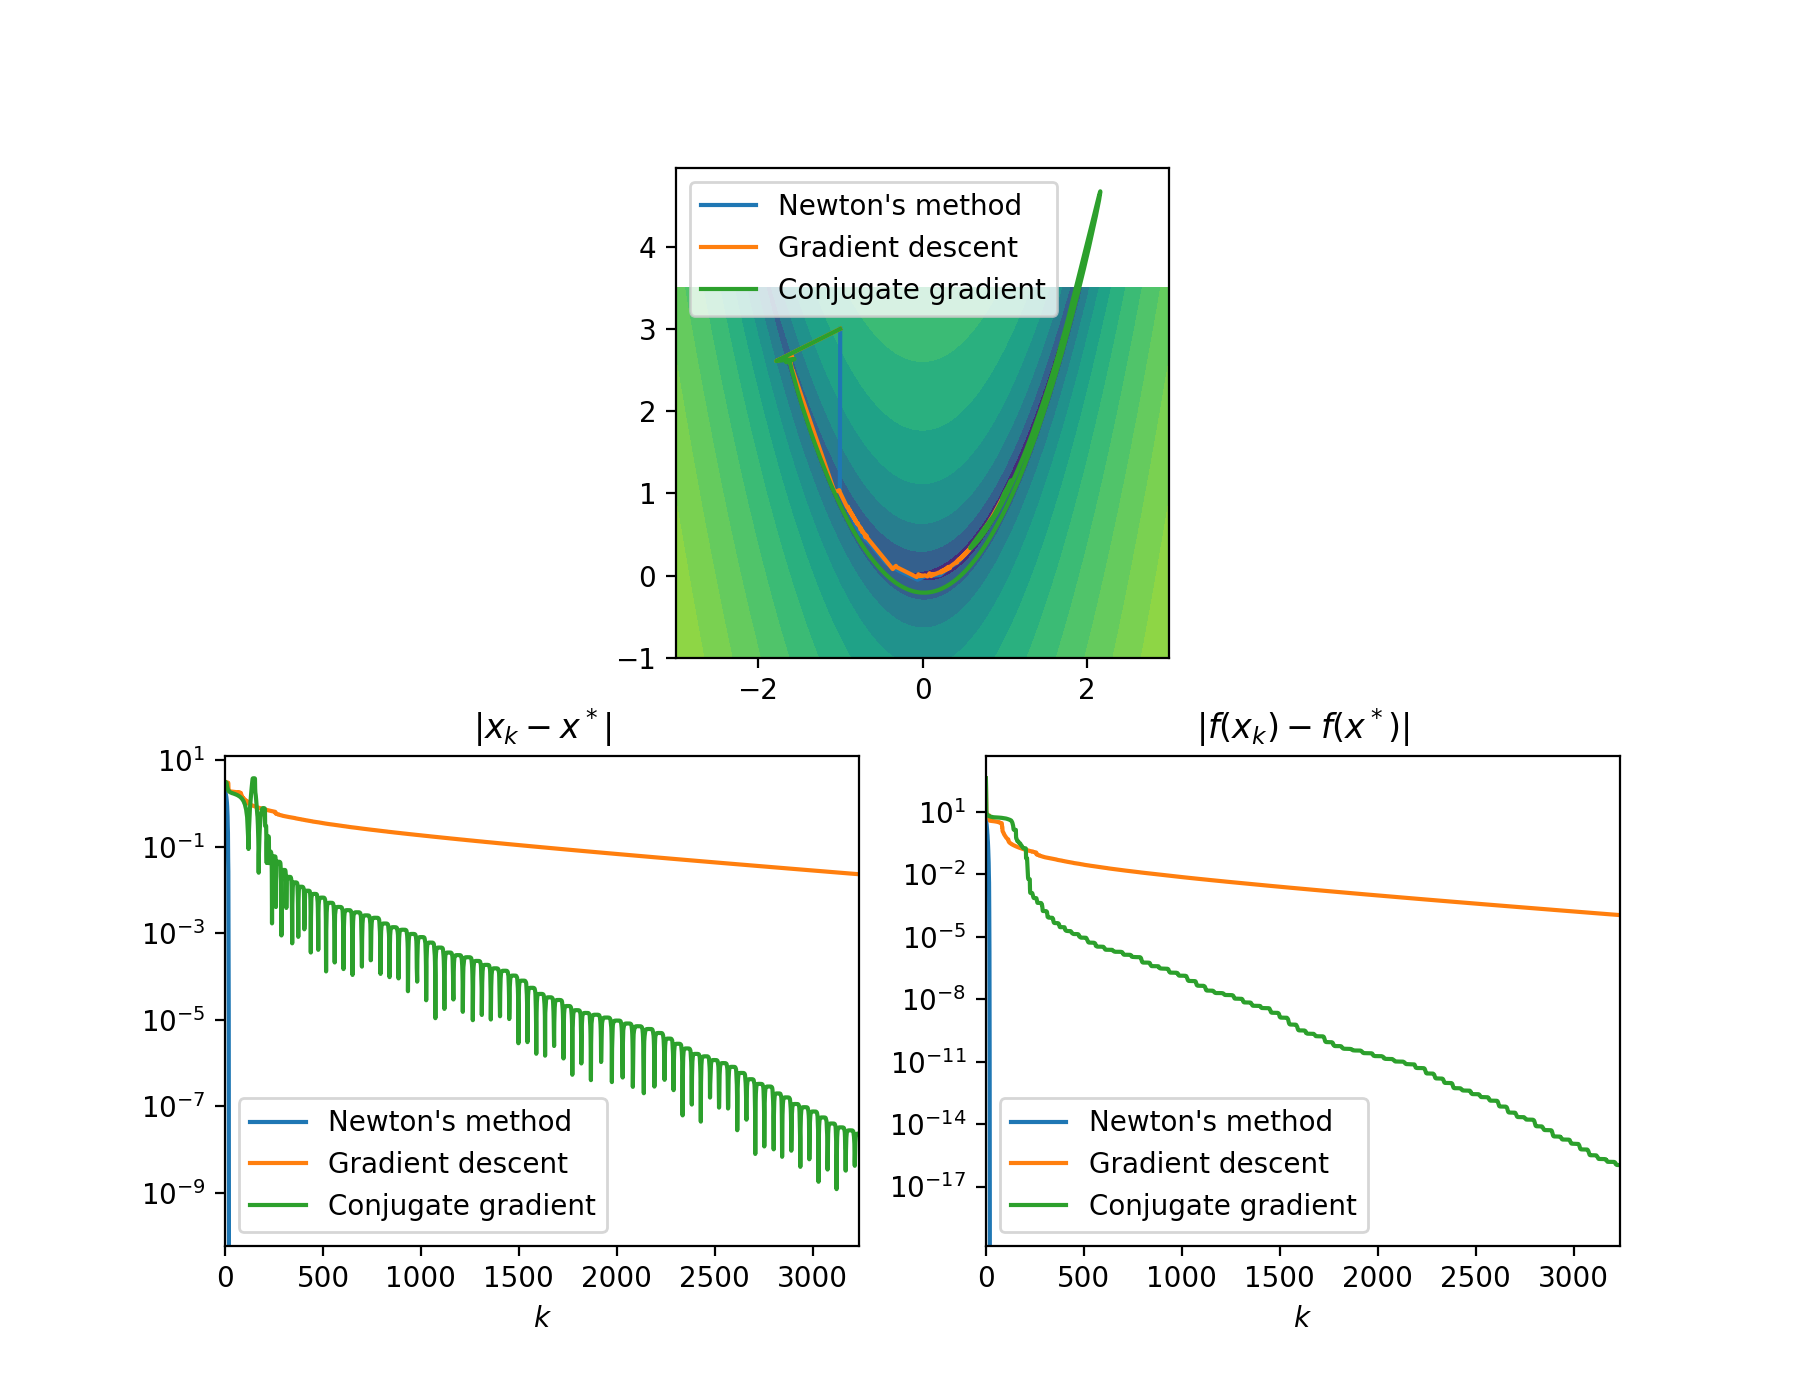

In [11]:
# Objective function and its gradient and Hessian
f = lambda x: 100*(x[1]-x[0]**2)**2 + (1-x[0])**2 
g = lambda x: np.array([
        -400*(x[1]-x[0]**2)*x[0] - 2*(1-x[0]), 
        200*(x[1]-x[0]**2)
    ])
H = lambda x: np.array([
        [-400*x[1]+1200*x[0]**2+2, -400*x[0]],
        [-400*x[0], 200]
    ])

# Initial conditions
x0 = np.array([-1,3])

# Sequences produced by the methods
xnewton = optimize(f, g, H, x0, method='newton')
xgd = optimize(f, g, H, x0, method='gd')
xfr = optimize(f,g,None,x0, method='cg', c2=0.4)


# Plot the results
plt.figure(figsize=(9,7))

# Plot the evolution of the methods
X,Y = np.meshgrid(np.linspace(-3,3,200), np.linspace(-1,3.5,200))
Z = np.apply_along_axis(f,2,np.concatenate((X[:,:,None],Y[:,:,None]),axis=2))
ax1 = plt.subplot(211)
#ax1.contourf(X,Y,Z,levels=np.linspace(0,10,20)**5, cmap='cmo.deep', locator=ticker.LogLocator())
ax1.contourf(X,Y,Z,levels=np.linspace(0,10,20)**5, locator=ticker.LogLocator())
ax1.plot(xnewton[:,0], xnewton[:,1],label='Newton\'s method')
ax1.plot(    xgd[:,0],     xgd[:,1], label='Gradient descent')
ax1.plot(    xfr[:,0],     xfr[:,1], label='Conjugate gradient')
ax1.set_aspect('equal')
ax1.legend()

# Backward error
ax2 = plt.subplot(223)
ax2.plot(np.linalg.norm(xnewton-[[1,1]],axis=1), label='Newton\'s method')
ax2.plot(np.linalg.norm(    xgd-[[1,1]],axis=1), label='Gradient descent')
ax2.plot(np.linalg.norm(    xfr-[[1,1]],axis=1), label='Conjugate gradient')
ax2.legend()
plt.xlabel('$k$')
plt.title('$|x_k-x^*|$')
plt.yscale('log')
plt.xlim(0, max(xnewton.shape[0], xfr.shape[0]))

# Forward error
ax3 = plt.subplot(224)
ax3.plot(np.apply_along_axis(f, 1, xnewton), label='Newton\'s method')
ax3.plot(np.apply_along_axis(f, 1,     xgd), label='Gradient descent')
ax3.plot(np.apply_along_axis(f, 1,     xfr), label='Conjugate gradient')
ax3.legend()
plt.xlabel('$k$')
plt.title('$|f(x_k)-f(x^*)|$')
plt.yscale('log')
plt.xlim(0, max(xnewton.shape[0], xfr.shape[0]))

plt.show()

In [ ]:
# f: function to optimize
# g: gradient of the objective function
# H: Hessian of the objective function
# xk: sequence of points
# fk: function value at current point
# gk: gradient of objective function at the current point
# ak: current step length
# pkgk: pk^T * gk
# tol: tolerance parameter for the gradient
# epsilon: tolerance parameter to ensure a sufficiently negative search direction in Newton's method
# rho: scaling parameter used when increasing the initial step lenght guess in the line search
# c1, c2: parameters used in Wolfe conditions
# nmax: maximum number of iterations
# nmaxls: maximum number of iterations in the line search